In [1]:
from collections import defaultdict

import numpy as np
import pickle as pkl
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from scipy import sparse
from scipy.stats import kendalltau, spearmanr

import torch
import torch.nn as nn
from torch.optim import Adam

from IPython import display
import matplotlib.pyplot as plt

# 0. Данные

Я сделал за вас только первый шаг: выкачал через API (https://rating.chgk.info/) сайта рейтинга ЧГК все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат в формате pickle вот здесь:

https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip

In [2]:
players_path = 'data/players.pkl'
results_path = 'data/results.pkl'
tournaments_path = 'data/tournaments.pkl'


with open(players_path, 'rb') as fd:
    players_json = pkl.load(fd)
with open(results_path, 'rb') as fd:
    results_json = pkl.load(fd)
with open(tournaments_path, 'rb') as fd:
    tournaments_json = pkl.load(fd)

# 1. Обработка данных

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:

○ взять в тренировочный набор турниры с dateStart из 2019 года;

○ в тестовый — турниры с dateStart из 2020 года.

In [3]:
def get_data_by_year(year, train_flag=True):
    year = str(year)
    indexes = [tourn['id'] for tourn in tournaments_json.values()
               if year in tourn['dateStart']
              ]
    
    data = []
    for ind in indexes:
        if ind in results_json:
            tour_data = get_tournament_info(ind, train_flag)
            if tour_data:
                data.extend(tour_data)

    if train_flag:
        column_names = ['team_id', 'question_id', 'player_list', 'ans']
    else:
        column_names = ['tourn_id', 'player_list', 'position']
        
    df = pd.DataFrame(data, columns=column_names)
    return df


def get_tournament_info(tour_ind, train_flag):
    players = []
    positions = []
    answers = []
    
    num_questions = sum(tournaments_json[tour_ind]['questionQty'].values())
    
    for team in results_json[tour_ind]:
        if not team.get('mask', None) or len(team['mask']) != num_questions:
            continue
        players.append([player['player']['id'] for player in team['teamMembers'] if player])
        team_answers = [int(score == '1') for score in team['mask']]
        answers.append(team_answers)
        positions.append(team.get('position', None))
    
    if train_flag:    
        if not answers:
            return None
        return [(team_ind, f'{tour_ind}_{q_ind}', team, ans)
                for team_ind, team in enumerate(players) if team
                for q_ind, ans in enumerate(answers[team_ind])
               ]
    return [(tour_ind, players[team_ind], positions[team_ind]) 
            for team_ind in range(len(positions))]

In [4]:
train_df = get_data_by_year(2019, train_flag=True)
train_df = (train_df.explode('player_list')
            .rename(columns={'player_list': 'player_id'}))
train_df.head(3)

,team_id,question_id,player_id,ans
0,0,4772_0,6212,1
0,0,4772_0,18332,1
0,0,4772_0,18036,1


# 2. Простая логистическая регрессия

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

○ повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;

○ в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;

○ для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

In [5]:
player_enc = OneHotEncoder(sparse=True)
question_enc = OneHotEncoder(sparse=True)

players_train = player_enc.fit_transform(train_df[['player_id']])
question_train = question_enc.fit_transform(train_df[['question_id']])

train_sparse = sparse.hstack([players_train, question_train])

In [6]:
model = LogisticRegression(max_iter=500, random_state=23)
model.fit(train_sparse, train_df['ans'].values)

/Users/stepdan23/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, random_state=23)

# 3. Качество на тестовой выборке

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

○ предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

○ в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров .

In [7]:
test_df = get_data_by_year(2020, train_flag=False)
test_df.head(3)

,tourn_id,player_list,position
0,4957,"[30152, 30270, 27822, 28751, 27403, 4270]",1.0
1,4957,"[34936, 40877, 25177, 113703, 33792, 107161]",2.0
2,4957,"[33620, 21346, 13857, 46339, 37836, 19632]",3.0


In [8]:
n_players = len(player_enc.categories_[0])
players_rating = dict(zip(player_enc.categories_[0], model.coef_[0][:n_players]))

In [9]:
def calculate_team_score(players):
    return np.mean([players_rating.get(p_id, 0) for p_id in players])

In [10]:
test_df['pred_score'] = (test_df.apply(
    lambda x: calculate_team_score(x['player_list']), axis=1).fillna(0))

spearman_corr = abs(test_df.groupby('tourn_id').apply(
    lambda x: spearmanr(x['position'], x['pred_score']).correlation).mean())
kendall_corr = abs(test_df.groupby('tourn_id').apply(
    lambda x: kendalltau(x['position'], x['pred_score']).correlation).mean())
print(f'Spearman correlation {spearman_corr:.3f}')
print(f'Kendalltau correlation {kendall_corr:.3f}')

/Users/stepdan23/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/stepdan23/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spearman correlation 0.762
Kendalltau correlation 0.607


# 4. EM - модель

In [11]:
values = train_sparse.data
indices = np.vstack((train_sparse.row, train_sparse.col))

train_torch = torch.sparse.FloatTensor(
    torch.LongTensor(indices),
    torch.FloatTensor(values),
    torch.Size(train_sparse.shape)
)
y_train_torch = torch.from_numpy(train_df['ans'].values.astype('float32'))

In [12]:
class EMModel:
    def __init__(self, input_size, lr=0.1, n_iter=10):
        self.model = nn.Linear(input_size, 1)
        self.opt = Adam(self.model.parameters(), lr=lr)
        self.loss = nn.BCELoss()
        self.n_iter = n_iter
        
    def e_step(self, X, y, y_true):
        self.model.eval()
        
        with torch.no_grad():
            out = self.model(X).flatten()
            y_pred = torch.sigmoid(out)
            
        train_df['neg_ans_prob'] =  1 - y_pred.numpy()
        team_prob = train_df.groupby(['team_id', 'question_id']).agg({'neg_ans_prob': 'prod'})
        team_prob = 1 - train_df[['team_id', 'question_id']].merge(team_prob.reset_index())['neg_ans_prob']

        return torch.from_numpy((y_true * (y_pred / team_prob)).values.astype('float32'))
        
    def m_step(self, X, y):
        self.model.train()
        self.opt.zero_grad()

        out = self.model(X).flatten()
        loss = self.loss(torch.sigmoid(out), y)
        
        loss.backward()
        self.opt.step()

    def train_model(self, X_train, y_train, valid_df, verbose=True):
        val_loss_history = []
        
        y_new = y_train.detach().clone()
        for i in range(self.n_iter + 1):

            y_new = self.e_step(X_train, y_new, y_train)
            self.m_step(X_train, y_new)

            if verbose and i % 1 == 0:
                players_rating = dict(zip(player_enc.categories_[0],
                                          self.model.weight.data.flatten()[:n_players]))
                
                valid_df['pred_score'] = (valid_df.apply(
                    lambda x: np.mean([players_rating.get(p_id, 0) for p_id in x['player_list']]), axis=1))
                
                spearman_corr = abs(valid_df.groupby('tourn_id').apply(
                    lambda x: spearmanr(x['position'], x['pred_score']).correlation).mean())
                val_loss_history.append(spearman_corr)

                display.clear_output(wait=True)
                print(f'num epoch - {i}')
                print(f'Spearman correlation {spearman_corr:.3f}')
                plt.ylim(0, 1)
                plt.xlim(0, (self.n_iter) + 1)
                plt.plot(range(len(val_loss_history)), val_loss_history)
                plt.show()

num epoch - 23
Spearman correlation 0.579


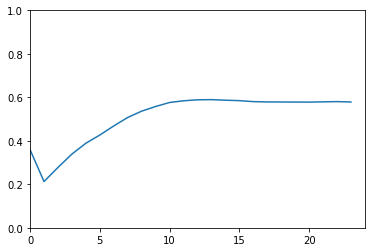

In [16]:
em_model = EMModel(train_torch.shape[1], lr=0.9, n_iter=23)
em_model.train_model(train_torch,  y_train_torch, test_df)

# 5. “рейтинг-лист” турниров

In [20]:
tourn_rating = defaultdict(int)
for quest_id, value in zip(question_enc.categories_[0], model.coef_[0][n_players:]):
    tourn_id = int(quest_id.split('_')[0])
    tourn_rating[tourn_id] += value
    
top_tournaments = sorted(tourn_rating.items(), key=lambda x: x[1])

top_10_tourn = [tournaments_json[ind]['name'] for ind, value in top_tournaments[:10]]
down_10_tourn = [tournaments_json[ind]['name'] for ind, value in top_tournaments[:-10:-1]]

print('Топ 10 сложных турниров по версии простой модели:', end='\n\n')
print('\n'.join(top_10_tourn), end='\n\n\n')
print('Топ 10 легких турниров по версии простой модели:', end='\n\n')
print('\n'.join(down_10_tourn))

Топ 10 сложных турниров по версии простой модели:

Чемпионат Санкт-Петербурга. Первая лига
Чемпионат Санкт-Петербурга. Высшая лига
Чемпионат России
Серия Гран-при. Общий зачёт
Угрюмый Ёрш
Кубок Москвы
Кубок городов
Синхрон высшей лиги Москвы
Первенство правого полушария
Воображаемый музей


Топ 10 легких турниров по версии простой модели:

Школьная лига
Шестой киевский марафон. Асинхрон
Школьный синхрон-lite. Сезон 3
Студенческая лига ЧТ
Малый кубок Физтеха
ОВСЧ
Первая лига ЧТ
 Балтийский Берег. Общий зачёт
Щит и Меч


In [21]:
tourn_rating = defaultdict(int)
for quest_id, value in zip(question_enc.categories_[0], 
                           em_model.model.weight.data.flatten()[n_players:]):
    tourn_id = int(quest_id.split('_')[0])
    tourn_rating[tourn_id] += value
    
top_tournaments = sorted(tourn_rating.items(), key=lambda x: x[1])

top_10_tourn = [tournaments_json[ind]['name'] for ind, value in top_tournaments[:10]]
down_10_tourn = [tournaments_json[ind]['name'] for ind, value in top_tournaments[:-10:-1]]

print('Топ 10 сложных турниров по версии EM модели:', end='\n\n')
print('\n'.join(top_10_tourn), end='\n\n\n')
print('Топ 10 легких турниров по версии EM модели:', end='\n\n')
print('\n'.join(down_10_tourn))

Топ 10 сложных турниров по версии EM модели:

Чемпионат Санкт-Петербурга. Первая лига
Чемпионат Санкт-Петербурга. Высшая лига
Серия Гран-при. Общий зачёт
Дзержинский марафон
Открытый Студенческий чемпионат Краснодарского края
Молодёжный чемпионат Нижегородской области
Чемпионат России
Школьный синхрон-lite. Сезон 3
Гран-при Славянки. Общий зачет
Школьная лига


Топ 10 легких турниров по версии EM модели:

Шестой киевский марафон. Асинхрон
Гран-при Славянки. Общий зачёт
Асинхрон по South Park
Студенческий чемпионат Калининградской области
Синхрон Лиги Разума
Олимпиада Приволжского федерального округа. Финал
One ring - async
(а)Синхрон-lite. Лига старта. Эпизод V
Второй тематический турнир имени Джоуи Триббиани


# Топ 20 игроков

In [22]:
top_20_player_ids = sorted(players_rating.items(), key=lambda x: x[1], reverse=True)[:20]
 
print('Топ 20 сильнейших игроков по версии простой модели:', end='\n\n')
for player_id, score in top_20_player_ids:
    player_info = players_json[player_id]
    num_quest = train_df[train_df['player_id'] == player_id].shape[0]
    
    print(player_info['surname'], player_info['name'],player_info['patronymic'],
          '| число вопросов:', num_quest, sep=' ')

Топ 20 сильнейших игроков по версии простой модели:

Руссо Максим Михайлович | число вопросов: 2195
Брутер Александра Владимировна | число вопросов: 2711
Семушин Иван Николаевич | число вопросов: 3803
Савченков Михаил Владимирович | число вопросов: 3236
Спешков Сергей Леонидович | число вопросов: 3767
Сорожкин Артём Сергеевич | число вопросов: 4885
Мереминский Станислав Григорьевич | число вопросов: 1595
Левандовский Михаил Ильич | число вопросов: 1470
Прокофьева Ирина Сергеевна | число вопросов: 1081
Николенко Сергей Игоревич | число вопросов: 2235
Новиков Илья Сергеевич | число вопросов: 1602
Саксонов Антон Владимирович | число вопросов: 1206
Либер Александр Витальевич | число вопросов: 3821
Гилёв Алексей Владимирович | число вопросов: 4485
Мосягин Александр Владимирович | число вопросов: 1123
Мокин Игорь Викторович | число вопросов: 1188
Марков Александр Валерьевич | число вопросов: 2917
Карякин Дмитрий Александрович | число вопросов: 1313
Царёв Михаил Сергеевич | число вопросов: 50

In [23]:
em_players_rating = dict(zip(player_enc.categories_[0],
                             em_model.model.weight.data.flatten()[:n_players]))

top_20_player_ids = sorted(em_players_rating.items(), key=lambda x: x[1], reverse=True)[:20]
 
print('Топ 20 сильнейших игроков по версии EM модели:', end='\n\n')
for player_id, score in top_20_player_ids:
    player_info = players_json[player_id]
    num_quest = train_df[train_df['player_id'] == player_id].shape[0]
    
    print(player_info['surname'], player_info['name'],player_info['patronymic'],
          '| число вопросов:', num_quest, sep=' ')

Топ 20 сильнейших игроков по версии EM модели:

Савенко София Романовна | число вопросов: 36
Антонов Алексей Валерьевич | число вопросов: 36
Бровченко Елена Борисовна | число вопросов: 36
Лебедева София Евгеньевна | число вопросов: 36
Лоренц Инга Андрисовна | число вопросов: 36
Мамбетов Сабит Бахитович | число вопросов: 36
Подюкова Валентина  | число вопросов: 36
Борок Дмитрий Владимирович | число вопросов: 849
Гринко Арина  | число вопросов: 216
Остросаблина Ольга Фёдоровна | число вопросов: 36
Зайдельман Семён Яковлевич | число вопросов: 36
Якутов Дмитрий Алексеевич | число вопросов: 36
Бирюкова Надежда Фёдоровна | число вопросов: 36
Микулин Илья Викторович | число вопросов: 36
Достовалов Сергей Григорьевич | число вопросов: 36
Савушкина Марина Юрьевна | число вопросов: 36
Глазкова Виолетта  | число вопросов: 36
Зацаринный Андрей Сергеевич | число вопросов: 36
Гаврилов Глеб Юрьевич | число вопросов: 252
Пилипенко Максим Игоревич | число вопросов: 36
